# 2.B. Cleaning and Engineering -- Lyrics

So far, we have collected a variety of datas from multiple sources-- we've grabbed lyrical data and user data from Genius.com; we've pulled down rap review text data from 3 sources; we have leveraged Spotify's API to retrieve audio features and preview URLS. Now, we are ready to move into the cleaning and engineering phase of the project. To begin, we'll first look at our lyrical data. The goal will be to take our lyrical data and clean it up significantly so that we can feature engineer. The workflow will be as follows:

1. Pull in our lyrical data from Genius.com
2. Remove **non-English** songs/artists
3. Perform a number of **cleaning** methods, inclusive of decontraction ('I'm' becomes 'I am') and treatment of non alphanumeric characters.
4. Incorporation of lyrical features, inclusive of: *number of lines, number of words, unique words, rhyme density*
5. Inorporate of lyrics features at the artist level, *inclusive of vocabulary size*
6. **Sentiment analysis**at the track level

These numerical features will be used to inform our recommender system. **We will dedicate a separate notebeook (3A) to our EDA / insights derived from these features.***

### Setup

In [1]:
import pandas as pd
import numpy as np
import time
import requests
import seaborn as sns
import warnings
import re
import sys
import nltk
import pronouncing

import nltk
from nltk.stem import PorterStemmer
from sklearn.model_selection import cross_val_score

In [2]:
genius_df = pd.read_csv('everything_ready_for_engineering_missing_genre.csv')

In [3]:
genius_df.shape

(25598, 35)

In [4]:
genius_df.columns

Index(['album', 'artist', 'date', 'features', 'lyrics', 'producers', 'song',
       'artist_clean', 'album_name_clean', 'track_clean', 'acousticness',
       'album_id', 'album_name', 'artist_id', 'danceability', 'duration_ms',
       'energy', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'preview_url', 'speechiness', 'tempo', 'time_signature',
       'track_href', 'track_id', 'track_name', 'uri', 'valence', 'genres',
       'pop', 'follower'],
      dtype='object')

In [5]:
genius_df.loc[genius_df.album_name_clean.isnull(), 'album_name_clean'] = 'exclamation mark'

In [6]:
genius_df = genius_df[genius_df['lyrics'].notnull()]

***
### Cleaning

#### Japanese and Spanish

In [7]:
#Manual checking has led us to the following list of artists for removal
genius_df = genius_df[genius_df['artist_clean'] != 'mc davo']
genius_df = genius_df[genius_df['artist_clean'] != 'marcelo d2']
genius_df = genius_df[genius_df['artist_clean'] != 'phyno']
genius_df = genius_df[genius_df['artist_clean'] != 'porta']
genius_df = genius_df[genius_df['artist_clean'] != 'valete'] 
genius_df = genius_df[genius_df['artist_clean'] != 'akwid'] 
genius_df = genius_df[genius_df['artist_clean'] != 'akira presidente']
genius_df = genius_df[genius_df['artist_clean'] != 'anirudh ravichander']
genius_df = genius_df[genius_df['artist_clean'] != 'kollegah']
genius_df = genius_df[genius_df['artist_clean'] != 'edo maajka']
genius_df = genius_df[genius_df['artist_clean'] != 'lary over'] 
genius_df = genius_df[genius_df['artist_clean'] != 'bob do contra']
genius_df = genius_df[genius_df['artist_clean'] != 'ajs nigrutin']
genius_df = genius_df[genius_df['artist_clean'] != 'dark polo gang']
genius_df = genius_df[genius_df['artist'] != 'Neutro Shorty']
genius_df = genius_df[genius_df['artist'] != 'Frenkie']
genius_df = genius_df[~genius_df['artist'].str.contains('[^\x00-\x7F]+')]

#### Deal With Contractions

In [8]:
#To help with NLP processing later, we're going to decontract words where possible. This will aid in the simplification of
#our text
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"isn\'t", "is not", phrase)
    phrase = re.sub(r"ain\'t", "is not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub("in' " , 'ing ', phrase)
    phrase = re.sub(" tha " , ' the ', phrase)
    phrase = re.sub(" da " , ' the ', phrase)
    phrase = re.sub(" dat " , ' that ', phrase)
    phrase = re.sub("in’ " , 'ing ', phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
#Apply our function to deonctract words where possible
genius_df['lyrics'] = genius_df['lyrics'].apply(decontracted)

#### Other Characters

In [10]:
#Manual checking has led to a number of cleaning steps in a particular order. See below for details
genius_df['cleaned_lyrics']  = genius_df['lyrics'].str.replace("in' " , 'ing')
genius_df['cleaned_lyrics']  = genius_df['cleaned_lyrics'].str.replace("in’ " , 'ing')
genius_df['cleaned_lyrics']  = genius_df['cleaned_lyrics'].str.replace("’", '')
genius_df['cleaned_lyrics']  = genius_df['cleaned_lyrics'].str.replace("'", '')
genius_df['cleaned_lyrics']  = genius_df['cleaned_lyrics'].str.replace("([\(\[]).*?([\)\]])", ' ', regex = True)
genius_df['cleaned_lyrics']  = genius_df['cleaned_lyrics'].str.replace('([ ]{2,})', ' ', regex = True) 
genius_df['cleaned_lyrics']  = genius_df['cleaned_lyrics'].str.replace('([^\s\w]|_)+', '', regex=True)
genius_df['cleaned_lyrics']  = genius_df['cleaned_lyrics'].str.replace('\'', '')
genius_df['cleaned_lyrics']  = genius_df['cleaned_lyrics'].str.replace("\s\s+", ' ', regex=True)
genius_df['cleaned_lyrics']  = genius_df['cleaned_lyrics'].str.replace('[^\x00-\x7F]+', '', regex=True)
genius_df['cleaned_lyrics']  = genius_df['cleaned_lyrics'].str.lower()
genius_df['cleaned_lyrics']  = genius_df['cleaned_lyrics'].str.strip()

In [11]:
#Some of our processing steps will require sentences broken out, we'll save these to another column for now
genius_df['split_lyrics'] = genius_df['cleaned_lyrics'].str.split('\n')

In [12]:
#For processes that just need words tokenized, as opposed to sentences, break things out by newlines
genius_df['cleaned_lyrics'] = genius_df['cleaned_lyrics'].str.replace('\n', ' ')

***
### Lyrical Engineering

We're now ready to move into the engineering stage of this process. Each step here is broken out for specific features.

In [74]:
#Grab the number of lines from our new column. This isn't perfect as it will pick up
#blanks, but each song has equal opportunity for this. For comparison, this isn't problematic
genius_df['number_lines'] = genius_df['split_lyrics'].apply(len)

### Track Features: Unique Words, Unique Word % of Total, Track Vocab Complexity

In [15]:
#Build a function to count syllables. We'll be using this a few different ways (rhyming)
#Source: https://stackoverflow.com/questions/46759492/syllable-count-in-python
def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

In [16]:
#Build list to hold our features for later appending to our dataframe
unique_words_list = []
total_words_list = []
unique_words_pct = []
track_complexity_list = []

#for every row of our dataframe
for index, row in genius_df.iterrows():
   
    #tokenize the row of lyrics into sep words
    temp_tokens = row['cleaned_lyrics'].split()
    
    #hold unique words per row
    unique_tokens = set(temp_tokens)
    
    #we haven't seen multisyllable words yet
    multisyllable_score = 0
    
    #for every word
    for token in unique_tokens:
        #count syllables
        syl_count = syllable_count(token)
        
        #if word is 3 or more syllables, increment our counter
        if syl_count > 2:
            multisyllable_score +=1
        else:
            pass
    
    #Calculate the % of unique words that are "complex", i.e. more than three syllables
    try:
        track_complexity_list.append(multisyllable_score/len(unique_tokens))
    except:
        track_complexity_list.append(0)
    
    #calculate percent unique words, total unique words and total words
    try:
        unique_words_pct.append(len(unique_tokens)/len(temp_tokens))
        unique_words_list.append(len(unique_tokens))
        total_words_list.append(len(temp_tokens))
    except:
        unique_words_pct.append(0)
        unique_words_list.append(len(unique_tokens))
        total_words_list.append(len(temp_tokens))


In [17]:
#Read our results into our dataframe
genius_df['track_unique_words_pct'] = unique_words_pct
genius_df['track_unique_words'] = unique_words_list
genius_df['track_complexity'] = track_complexity_list
genius_df['track_total_words'] = total_words_list

### Feature: Artist Vocabulary, Complexity

With our track level features in place, we also want to look at some artist level metrics. To do this, we'll create a separate pivot and aggregate all of our text data at the artist level. We'll be looking primarily at vocab size and lyrical complexity. Because some artists have been around longer than others, we're not going to look at every word, we'll only look at the first 5,000 words to even the playing field.

In [18]:
#build our separate dataframe for artist level analysis
all_lyrics_per_artist_df = genius_df.groupby(['artist_clean'])['cleaned_lyrics'].apply(','.join).reset_index()

In [19]:
#build our initial lists
unique_words_list = []
total_lyrics = []
vocab_complexity_list = []

#for every row of our artist df
for index, row in all_lyrics_per_artist_df.iterrows():
    
    #we havent seen any big words yet...
    multisyllable_score = 0
    
    #tokenize the first 5000 words for an artist
    temp_tokens = row['cleaned_lyrics'].split()
    temp_tokens = temp_tokens[:5001]
    
    #find the unique words
    unique_tokens = set(temp_tokens)
    
    #for each word, mark whether or not it's a big word
    for token in unique_tokens:
        syl_count = syllable_count(token)
        
        if syl_count > 2:
            multisyllable_score +=1
        else:
            pass
    
    #append our counts
    unique_words_list.append(len(unique_tokens))
    total_lyrics.append(len(temp_tokens))
    
    #append our complexity score 
    try:
        vocab_complexity_list.append(multisyllable_score/len(unique_tokens))
    except:
        vocab_complexity_list.append(0)
    


In [20]:
#read into out dataframe
all_lyrics_per_artist_df['artist_vocab_size'] = unique_words_list
all_lyrics_per_artist_df['artist_vocab_complexity'] = vocab_complexity_list

In [22]:
#reduce to the columns that we care about
all_lyrics_per_artist_df = all_lyrics_per_artist_df[['artist_clean','artist_vocab_size', 'artist_vocab_complexity']]

In [23]:
genius_df.columns

Index(['album', 'artist', 'date', 'features', 'lyrics', 'producers', 'song',
       'artist_clean', 'album_name_clean', 'track_clean', 'acousticness',
       'album_id', 'album_name', 'artist_id', 'danceability', 'duration_ms',
       'energy', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'preview_url', 'speechiness', 'tempo', 'time_signature',
       'track_href', 'track_id', 'track_name', 'uri', 'valence', 'genres',
       'pop', 'follower', 'cleaned_lyrics', 'split_lyrics', 'number_lines',
       'track_unique_words_pct', 'track_unique_words', 'track_complexity',
       'track_total_words'],
      dtype='object')

In [24]:
#merge back to our original dataframe
genius_df = pd.merge(genius_df, all_lyrics_per_artist_df, how='left', on='artist_clean')

### Rhyme Density

Our last major engineering project before going into sentiment data is looking at **rhyme density**, which is a metric inspired by the below project, *DopeLeaning* from Eric Malmi and team:

https://github.com/ekQ/dopelearning
https://arxiv.org/abs/1505.04771


Rhyme density approximates the "skill" of a rapper by assessing internal rhymes/assonane rhymes for a set of a lyrics. Genius.com has their own definition and examples here:

https://genius.com/posts/63-Introducing-rapmetricstm-the-birth-of-statistical-analysis-of-rap-lyrics

Eric leverage the actual phonemes for every line to build this feature. For us, we will simply be going word by word in each line and leveraging a library called **pronouncing** to assess rhyme candidates at the line level. This goes beyond the typical A/B/A/B or A/A/B/B rhyme scheme of rap and looks for possible rhymes within each line as a proxy for some of the phonetic work done by Eric. With more time, we'd like to replace this approach.

In [26]:
#rhyme density function to assess internal rhymes
def rhyme_density(strings):
    
        #initiate empty list to hold our calculations
        average_internal_rhyme_pct_list = []

        #for every line
        for string in strings:
            
            #empy list of possible rhymes in the line
            rhyme_options = []


            #break out the words in the line
            for i in string.split():
                
                #store the words that rhyme with each word we're iterating through
                rhyme_options.extend(pronouncing.rhymes(i))
            
            #no rhymes yet
            rhyme_candidates = 0
            
            #for every word
            for i in string.split():
                
                #if that word is in the rhyme options list we built
                if (i in rhyme_options):
                    
                    #increment our score
                    rhyme_candidates +=1 
                    
            #calculate internal rhyme ratio for the line
            try:
                average_internal_rhyme_pct_list.append(rhyme_candidates / len(string.split()))
            except:
                average_internal_rhyme_pct_list.append(0)
                
        #calulate at the track level
        try:
            avg = sum(average_internal_rhyme_pct_list)/len(average_internal_rhyme_pct_list)
        except:
            avg = 0
            
        return(avg)

In [27]:
#Read back into our dataset
genius_df['track_rhyme_density'] = genius_df['split_lyrics'].apply(rhyme_density)

### LDA

https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da

#### Topics

In [17]:
# #
# #https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# #

# import re
# import numpy as np
# import pandas as pd
# from pprint import pprint

# # Gensim
# import gensim
# import gensim.corpora as corpora
# from gensim.utils import simple_preprocess
# from gensim.models import CoherenceModel

# # spacy for lemmatization
# import spacy

# # Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
# import matplotlib.pyplot as plt
# %matplotlib inline

# # Enable logging for gensim - optional
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# import warnings
# warnings.filterwarnings("ignore",category=DeprecationWarning)

In [34]:
# #filter out stopwords, filtering out financial lexicon (?)
# from nltk.corpus import stopwords
# stop = stopwords.words('english')

In [36]:
# genius_df['cleaned_lyrics_for_topics'] = genius_df['cleaned_lyrics'].apply(strip_words)

In [47]:
# genius_df['cleaned_lyrics_for_topics'] = genius_df['cleaned_lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [64]:
# from nltk.stem.wordnet import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()
# topic_docs = list(genius_df['cleaned_lyrics'].str.split())

In [68]:
# genius_df['cleaned_lyrics'][0]

In [69]:
# bigram = gensim.models.Phrases(topic_docs, min_count=5, threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[topic_docs], threshold=100)  

# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

In [57]:
# # def remove_stopwords(texts):
# #     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# def make_bigrams(texts):
#     return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

In [70]:
# # Form Bigrams
# data_words_bigrams = make_bigrams(topic_docs)

# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:1])

In [59]:
# # Create Dictionary
# id2word = corpora.Dictionary(data_lemmatized)

# # Create Corpus
# texts = data_lemmatized

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

# # dictionary_LDA.filter_extremes(no_below=20, no_above=0.2)


In [60]:
# # Build LDA model
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=10, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)

In [71]:
# # Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [72]:
# # Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

In [73]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

Locations and People

In [1955]:
nlp = en_core_web_sm.load()
ex = strip_words(genius_df['lyrics'][3400])
doc = nlp(ex)

### Song Sentiment -- VADER / Word Based

We'd also like to take some time here to look at sentiment for our lyrics. There are a number of packages available for analysis here-- for our purposes we'll be leveraging **VADER**, a popular python library for this purpose. Here's a quick snippet on how this library works:

Taken from: https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/


*VADER (Valence Aware Dictionary and sEntiment Reasoner) is a **lexicon and rule-based sentiment analysis** tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labeled according to their semantic orientation as either positive or negative. VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.*

*The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).*

*positive sentiment : (compound score >= 0.05)*

*neutral sentiment : (compound score > -0.05) and (compound score < 0.05)*

*negative sentiment : (compound score <= -0.05)*

Several attempts were made for sentiment analysis using a variety of techniques and pre-processing. What we've found is that the removal of profanity allows us to get a cleaner understanding of sentiment as it relates to the topics/sentences themselves. Profanity is quite frequent and ubuquitous in rap-- from Kendrick Lamar to Gucci Mane-- and is not particularly revealing on it's own. For that reason. 

#### Irrelevant Words

In [14]:
bad_words = pd.read_csv('lyricsclean/bad-words.csv', header=None)

In [15]:
bwlist = bad_words.rename(columns={0:'words'})['words'].to_list()

In [31]:
def strip_words(phrase):
    
    list_to_remove = ['niggas', 'nigga', 'bros', 'hoes', 'hoe', 'fucking', 'fuck', 'shits', 'shit', 'bitches', 'bitch', 'asshole', 'cocksucker', 'cunt', 'faggot', 'hoes', 'thots', 'thot',  'pussies', 'pussy']
    list_of_adlibs = [' ay ', ' aye ', ' yay ', ' yea ', ' woo ', ' huh', ' uhh ', ' bam ', ' sheesh ']

    list_to_remove.extend(list_of_adlibs)
    list_to_remove.extend(bwlist)

    for word in list_to_remove:
        phrase = re.sub(word, ' ', phrase)
    
    phrase = re.sub(r"\s\s+", " ", phrase)
    phrase = phrase.strip()

    return phrase

#### Clean Up, Calculate at Track Level

In [34]:
#remove numbers
### Song Sentiment -- VADER / Word Based

genius_df['cleaned_lyrics_for_sentiment'] = genius_df['cleaned_lyrics'].str.replace('\d+', '', regex=True)

genius_df['cleaned_lyrics_for_sentiment'] = genius_df['cleaned_lyrics_for_sentiment'].apply(strip_words)

genius_df['cleaned_lyrics_for_sentiment'] = genius_df['cleaned_lyrics_for_sentiment'].str.strip().str.strip()

In [35]:
#filter out stopwords, filtering out financial lexicon (?)
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [36]:
genius_df['cleaned_lyrics_for_sentiment'] = genius_df['cleaned_lyrics_for_sentiment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [37]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [38]:
sid_obj = SentimentIntensityAnalyzer()

In [33]:
print('he')

he


In [39]:
neg_list = []
pos_list = []
neu_list = []
comp_list = []
for index, row in genius_df.iterrows():
    
    try:
        sentiment_dict = sid_obj.polarity_scores(row['cleaned_lyrics_for_sentiment'])
        neg_list.append(round(sentiment_dict['neg'], 2))
        pos_list.append(round(sentiment_dict['pos'], 2))
        neu_list.append(round(sentiment_dict['neu'], 2))
        comp_list.append(round(sentiment_dict['compound'], 2))
    except:
        pass
        
       

In [40]:
len(neg_list), len(pos_list), len(neu_list), len(comp_list)

(25130, 25130, 25130, 25130)

In [41]:
comp_list[2], neg_list[2], pos_list[2]

(-0.99, 0.2, 0.06)

In [42]:
genius_df['sentiment_track_neg'] = neg_list
genius_df['sentiment_track_pos'] = pos_list
genius_df['sentiment_track_neu'] = neu_list
genius_df['sentiment_track_comp'] =  comp_list

#### Emotion Word Counts

In [43]:
filepath = './sentiment/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'

emotion_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emotion_df.head(5)

,word,emotion,association
0,abandonment,joy,0
1,abandonment,negative,1
2,abandonment,positive,0
3,abandonment,sadness,1
4,abandonment,surprise,1


In [44]:
emotion_df.shape

(141776, 3)

In [45]:
emotion_df = emotion_df.pivot(index='word', columns='emotion', values='association').reset_index()

In [46]:
sad_list = list(emotion_df.loc[(emotion_df.sadness == 1), 'word'])
angry_list = list(emotion_df.loc[(emotion_df.anger == 1), 'word'])
joy_list = list(emotion_df.loc[(emotion_df.joy == 1), 'word'])
anticipation_list = list(emotion_df.loc[(emotion_df.anticipation == 1), 'word'])
trust_list = list(emotion_df.loc[(emotion_df.trust == 1), 'word'])
fear_list = list(emotion_df.loc[(emotion_df.fear == 1), 'word'])
disgust_list = list(emotion_df.loc[(emotion_df.disgust == 1), 'word'])
surprise_list = list(emotion_df.loc[(emotion_df.surprise == 1), 'word'])


sad_words = []
angry_words = []
joy_words = []
ant_words = []
trust_words = []
fear_words = []
disgust_words = []
surprise_words = []


for index, row in genius_df.iterrows():
    
    sad = 0
    angry = 0
    joy = 0
    ant = 0
    trust = 0
    fear = 0
    disgust = 0
    surprise = 0
    
    
    word_count = len(row['cleaned_lyrics_for_sentiment'].split())
    
    for word in row['cleaned_lyrics_for_sentiment'].split():
        
        if word in sad_list:
            sad +=1
        if word in angry_list:
            angry +=1
        if word in joy_list:
            joy +=1
        if word in anticipation_list:
            ant +=1
        if word in trust_list:
            trust +=1
        if word in fear_list:
            fear +=1
        if word in disgust_list:
            disgust +=1
        if word in surprise_list:
            surprise +=1

    sad_words.append(int(sad))
    angry_words.append(int(angry))
    joy_words.append(int(joy))
    ant_words.append(int(ant))
    trust_words.append(int(trust))
    fear_words.append(int(fear))
    disgust_words.append(int(disgust))
    surprise_words.append(int(surprise))
    
            

In [47]:
genius_df['track_sad_words'] = sad_words
genius_df['track_angry_words'] = angry_words
genius_df['track_joy_words'] = joy_words
genius_df['track_ant_words'] = ant_words
genius_df['track_trust_words'] = trust_words
genius_df['track_fear_words'] = fear_words
genius_df['track_disgust_words'] = disgust_words
genius_df['track_surprise_words'] = surprise_words

#### Emotion Words for EDA 

In [48]:
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentence = genius_df['cleaned_lyrics'][40]
tokenized_sentence = nltk.word_tokenize(sentence)

sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for word in tokenized_sentence:
    if (sid.polarity_scores(word)['compound']) >= 0.5:
        pos_word_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -0.5:
        neg_word_list.append(word)
    else:
        neu_word_list.append(word)                

print('Positive:',pos_word_list)            
print('Negative:',neg_word_list) 
score = sid.polarity_scores(sentence)#### Clean Up, Calculate at Track Level

Positive: ['joy', 'joy']
Negative: ['motherfucking', 'motherfucking', 'motherfucking', 'motherfucking', 'bitches', 'motherfucking', 'motherfucking', 'motherfucking', 'bitches', 'bitches', 'bitch', 'shit', 'motherfucking', 'motherfucking', 'motherfucking']


In [131]:
#ok, now get this into the dataframe

In [50]:
genius_df.to_csv('cleaned_with_sentiment_needs_review.csv', index=False)

# Phonemes

In [79]:
arpabet = nltk.corpus.cmudict.dict()

for word in ('s', 'see', 'sea', 'compute', 'comput', 'seesea'):
    try:
        print(arpabet[word][0])
    except Exception as e:
        print('')

['EH1', 'S']
['S', 'IY1']
['S', 'IY1']
['K', 'AH0', 'M', 'P', 'Y', 'UW1', 'T']


### EDA on some of these features

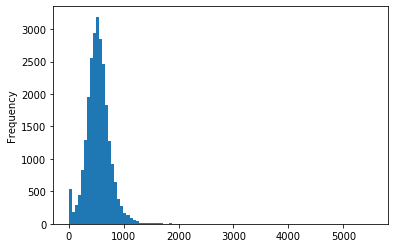

In [1917]:
genius_df.track_total_words.plot(kind='hist', bins=100);

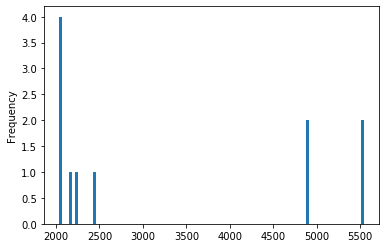

In [1921]:
genius_df.loc[genius_df.track_total_words > 2000, 'track_total_words'].plot(kind='hist', bins=100);

In [1922]:
genius_df.loc[genius_df.track_total_words > 2000, 'track_total_words']

2003     4881
2004     4881
7277     5542
7278     5542
11515    2173
11539    2059
11540    2059
12972    2231
20275    2455
23858    2039
24485    2055
Name: track_total_words, dtype: int64

In [1930]:
genius_df[genius_df['cleaned_lyrics'].str.contains('that nigga big ass moe chilling')]

,album,artist,date,features,lyrics,producers,song,artist_clean,album_name_clean,track_clean,...,sentiment_track_neu,sentiment_track_comp,track_sad_words,track_angry_words,track_joy_words,track_ant_words,track_trust_words,track_fear_words,track_disgust_words,track_surprise_words
7277,NaN,Fat Pat,"266 1998.352941\nName: date, dtype: float64",[],[Intro: Big Moe]\nThat nigga Big Ass Moe\nChil...,[],All About My Doe,fat pat,fat pat,all about my doe,...,78,-99,83,104,62,129,117,93,100,124
7278,NaN,Fat Pat,"266 1998.352941\nName: date, dtype: float64",[],[Intro: Big Moe]\nThat nigga Big Ass Moe\nChil...,[],All About My Doe,fat pat,fat pat,all about my doe,...,78,-99,83,104,62,129,117,93,100,124


### Topic Extraction

In [135]:
from gensim import corpora, models

In [136]:
topic_docs = list(genius_df['cleaned_lyrics_for_sentiment'].str.split())

In [143]:
dictionary_LDA = corpora.Dictionary( topic_docs)

In [144]:
dictionary_LDA.filter_extremes()

In [145]:
corpus = [dictionary_LDA.doc2bow(doc) for doc in topic_docs]

In [146]:
num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

Wall time: 2min 7s


In [147]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.061*"money" + 0.011*"work" + 0.011*"getting" + 0.010*"game" + 0.009*"cash" + 0.008*"paper" + 0.008*"e" + 0.007*"keep" + 0.006*"hard" + 0.006*"le"

1: 0.021*"yo" + 0.010*"wit" + 0.009*"ya" + 0.008*"em" + 0.008*"man" + 0.007*"come" + 0.006*"od" + 0.006*"c" + 0.006*"hit" + 0.006*"real"

2: 0.015*"lil" + 0.012*"new" + 0.012*"money" + 0.009*"pull" + 0.009*"diamonds" + 0.009*"ama" + 0.009*"gon" + 0.008*"gang" + 0.008*"shawty" + 0.008*"bag"

3: 0.035*"ya" + 0.020*"ride" + 0.011*"pop" + 0.011*"drop" + 0.011*"south" + 0.010*"side" + 0.009*"thang" + 0.009*"bounce" + 0.009*"throw" + 0.008*"slow"

4: 0.016*"time" + 0.012*"never" + 0.012*"would" + 0.012*"ut" + 0.010*"said" + 0.010*"man" + 0.009*"gotta" + 0.008*"e" + 0.007*"still" + 0.007*"told"

5: 0.034*"want" + 0.031*"em" + 0.030*"gon" + 0.026*"say" + 0.020*"tell" + 0.018*"tryna" + 0.018*"way" + 0.017*"really" + 0.015*"yeah" + 0.015*"bout"

6: 0.178*"wanna" + 0.132*"life" + 0.041*"thug" + 0.034*"live" + 0.031*"living" + 0.024*"world" + 0.016

In [ ]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)